In [1]:
from utility import *
from constant import *
with open('account.txt', 'r') as f:
    accounts = [s.strip() for s in f.readlines()]

account = accounts[3]

IBMProvider.save_account(account, overwrite=True)

provider = IBMProvider(instance='ibm-q/open/main')
backend = provider.get_backend('ibm_brisbane')

In [2]:
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

def switch_account(index):
    account = accounts[index]
    IBMProvider.save_account(account, overwrite=True)
    provider = IBMProvider(instance='ibm-q/open/main')
    backend = provider.get_backend('ibm_brisbane')
    print(f'Account {index} is being used')
    return provider, backend

In [98]:
#you can start here because some of packages have already imported
#and this code don't require any special pre-defined function in my utility
qubit = 109
f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9
f12 = f01 + anhar

num_qubits = qubit + 1
num_clbits = 1

In [7]:
dur12 = 120
sig12 = dur12/4
amp12 = 0.15251239315790388
beta12 = 0

In [12]:
with pulse.build(backend=backend, name=r'$X^{12}_{\pi}$') as xpi12:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(f12, drive_chan)
    pulse.play(pulse.Gaussian(duration=dur12, sigma=sig12,
                              amp=amp12, name=r'$X^{12}_{\pi}$'), drive_chan)

In [100]:
#this is two main functions you will need to customize measure pulse of ibm
#for an arbitrary circuit, you only need use add_calibration method on "measure" instruction
def create_measure_pulse(shift_frequency, measure_amplitude, measure_angle):
    with pulse.build(backend=backend, name='Spectroscopy') as measure_schedule:
        #define channel
        meas_chan = pulse.measure_channel(qubit)
        pulse.shift_frequency(shift_frequency*MHz, meas_chan)
        ac_chan = pulse.acquire_channel(qubit)
        mem_chan = pulse.MemorySlot(0)
        #define pulse shape
        pulse.acquire(1440, ac_chan, mem_chan)
        pulse.play(pulse.GaussianSquare(amp=measure_amplitude, duration=1440,
                                        sigma=32, width=1312,
                                        angle=measure_angle), meas_chan)
        #add delay
        pulse.delay(1160, meas_chan)
    return measure_schedule

def create_discriminator_circuit(measure_pulse):

    Xpi12 = Gate('X12', 1, [])
    
    zero = QuantumCircuit(num_qubits, num_clbits)
    zero.measure(qubit, 0)
    zero.add_calibration('measure', (qubit, ), measure_pulse, [])

    one = QuantumCircuit(num_qubits, num_clbits)
    one.x(qubit)
    one.measure(qubit, 0)
    one.add_calibration('measure', (qubit, ), measure_pulse, [])

    two = QuantumCircuit(num_qubits, num_clbits)
    two.x(qubit)
    two.append(Xpi12, [qubit])
    two.measure(qubit, 0)
    two.add_calibration(Xpi12, (qubit, ), xpi12, [])
    two.add_calibration('measure', (qubit, ), measure_pulse, [])

    discr_circs = [zero, one, two, zero, zero, zero]

    #discr_circs = [circ.add_calibration('measure', (qubit, ), measure_pulse, []) for circ in discr_circ]

    return discr_circs

In [101]:
meas_amps = np.arange(0.1, 0.039, -0.01)
meas_shift_freqs = np.arange(-1, -0.3, 0.1)
#this is the default angle of IBM, do we need to calibrate it ?
measure_angle = 1.330056315168335

In [66]:
exp_circs = []
for amp in meas_amps:
    for shift_freq in meas_shift_freqs:
        meas_pulse = create_measure_pulse(shift_freq, amp, measure_angle)
        discr_circs = create_discriminator_circuit(meas_pulse)
        exp_circs += discr_circs

In [67]:
len(exp_circs)

294

In [70]:
job = backend.run(exp_circs, meas_level=1, meas_return='single', shots=2000)

In [71]:
job.job_id()

'ctvkj7066x8g008q520g'

In [72]:
job_monitor(job)

Job Status: job has successfully run


In [73]:
job_data = [job.result().get_memory(i)*1e-7 for i in range(len(job.result().results))]

In [102]:
#length of one discriminator circuit (included trash circuits)
N = 6

In [96]:
nrows = 7
ncols = 7

#len circs
N = 5

fig, axs = plt.subplots(nrows, ncols, figsize=(49*2, 49*2))

for i in range(nrows):
    for j in range(ncols):
        index_1D = nrows * i + j
        discr_circ = job_data[index_1D*(N-1):(index_1D+1)*(N-1)]
        zero, one, two = discr_circ[:3]
        axs[i][j].scatter(np.real(zero), np.imag(zero), color='blue', s=10)
        axs[i][j].scatter(np.real(one), np.imag(one), color='red', s=10)
        axs[i][j].scatter(np.real(two), np.imag(two), color='green', s=10)
        axs[i][j].set_title(f'amp={meas_amps[i]}, shift_freq={meas_shift_freqs[j]}')

In [83]:
nrows = 7
ncols = 7

In [93]:
meas_amps[0], meas_shift_freqs[6]

(0.1, -0.40000000000000013)

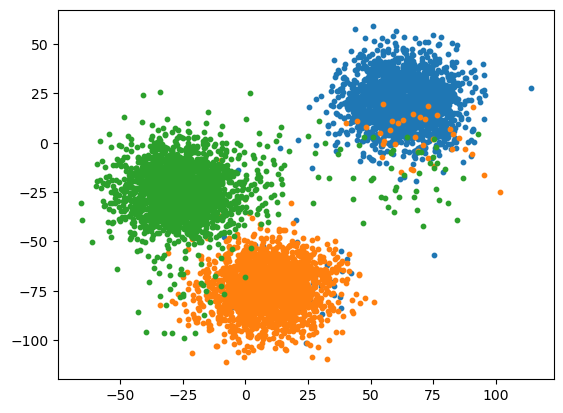

In [92]:
plt.scatter(np.real(job_data[30]), np.imag(job_data[30]), s=10)
plt.scatter(np.real(job_data[31]), np.imag(job_data[31]), s=10)
plt.scatter(np.real(job_data[32]), np.imag(job_data[32]), s=10)

In [80]:
for i in range(nrows):
    for j in range(ncols):
        index_1D = nrows * i + j
        print(index_1D*N,(index_1D+1)*N)

0 6
6 12
12 18
18 24
24 30
30 36
36 42
42 48
48 54
54 60
60 66
66 72
72 78
78 84
84 90
90 96
96 102
102 108
108 114
114 120
120 126
126 132
132 138
138 144
144 150
150 156
156 162
162 168
168 174
174 180
180 186
186 192
192 198
198 204
204 210
210 216
216 222
222 228
228 234
234 240
240 246
246 252
252 258
258 264
264 270
270 276
276 282
282 288
288 294
